<a href="https://colab.research.google.com/github/neutral-technician/Induction_Motor_Fault_Detection/blob/main/AI_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [367]:
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from scipy import signal
import tensorflow as tf
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [368]:
INPUT_DATA_DIR = Path('/content/gdrive/My Drive/fault_data')#path the the normal and imbalanced data
NORMAL_FILE_NAMES = glob.glob(str(INPUT_DATA_DIR)+'/normal/*.csv') #returns list of path names
print (NORMAL_FILE_NAMES)
IMB_SIX = glob.glob(str(INPUT_DATA_DIR)+'/imbalance/6g/*.csv')
IMB_TEN = glob.glob(str(INPUT_DATA_DIR)+'/imbalance/10g/*.csv')
IMB_FIFTEEN = glob.glob(str(INPUT_DATA_DIR)+'/imbalance/15g/*.csv')
IMB_TWENTY = glob.glob(str(INPUT_DATA_DIR)+'/imbalance/20g/*.csv')
IMB_TWENTY_FIVE = glob.glob(str(INPUT_DATA_DIR)+'/imbalance/25g/*.csv')
IMB_THIRTY = glob.glob(str(INPUT_DATA_DIR)+'/imbalance/30g/*.csv')
IMB_THIRTY_FIVE = glob.glob(str(INPUT_DATA_DIR)+'/imbalance/35g/*.csv')

['/content/gdrive/My Drive/fault_data/normal/12.288.csv', '/content/gdrive/My Drive/fault_data/normal/13.1072.csv', '/content/gdrive/My Drive/fault_data/normal/14.336.csv', '/content/gdrive/My Drive/fault_data/normal/15.1552.csv', '/content/gdrive/My Drive/fault_data/normal/16.1792.csv', '/content/gdrive/My Drive/fault_data/normal/17.2032.csv', '/content/gdrive/My Drive/fault_data/normal/18.432.csv', '/content/gdrive/My Drive/fault_data/normal/19.6608.csv', '/content/gdrive/My Drive/fault_data/normal/20.2752.csv', '/content/gdrive/My Drive/fault_data/normal/21.7088.csv', '/content/gdrive/My Drive/fault_data/normal/23.552.csv', '/content/gdrive/My Drive/fault_data/normal/22.3232.csv', '/content/gdrive/My Drive/fault_data/normal/24.576.csv', '/content/gdrive/My Drive/fault_data/normal/25.6.csv', '/content/gdrive/My Drive/fault_data/normal/26.624.csv', '/content/gdrive/My Drive/fault_data/normal/27.4432.csv', '/content/gdrive/My Drive/fault_data/normal/29.4912.csv', '/content/gdrive/My Dr

In [369]:
def dataReader(pathNames):  
    dataset = pd.DataFrame()

    for i in pathNames: #loop through all pathnames
        data_read = pd.read_csv(i, header=None) #read csv
        dataset= pd.concat([dataset,data_read], ignore_index=True) #add data to dataset

    return dataset

In [370]:
dataNormal = dataReader(NORMAL_FILE_NAMES) #call dataReader function and return dataset
data_six= dataReader(IMB_SIX) #repeat for all folders
data_ten= dataReader(IMB_TEN)
data_fifteen= dataReader(IMB_FIFTEEN)
data_twenty= dataReader(IMB_TWENTY)
data_twenty_five= dataReader(IMB_TWENTY_FIVE)
data_thirty= dataReader(IMB_THIRTY)
data_thirty_five= dataReader(IMB_THIRTY_FIVE)

In [371]:
empties=[
dataNormal.isnull().values.any(),
data_six.isnull().values.any(),
data_ten.isnull().values.any(),
data_fifteen.isnull().values.any(),
data_twenty.isnull().values.any(),
data_twenty_five.isnull().values.any(),
data_thirty.isnull().values.any(),
data_thirty_five.isnull().values.any()]
empties #if all false, no empty data rows

[False, False, False, False, False, False, False, False]

In [372]:
def downSampler(data,dB,d):
    data_decreased = pd.DataFrame()
    x = d #number we divide sample size by
    for i in range(int(len(data)/x)): #from 0 to data length/input
        data_decreased = data_decreased.append(data.iloc[dB:d,:].sum()/x,ignore_index=True)
        dB += x
        d += x
    return data_decreased

In [373]:
dataNormal = downSampler(dataNormal, 0, 2000) #sampling rate set to 2000
data6g = downSampler(data_six, 0, 2000)
data10g = downSampler(data_ten, 0, 2000)
data15g = downSampler(data_fifteen, 0, 2000)
data20g = downSampler(data_twenty, 0, 2000)
data25g = downSampler(data_twenty_five, 0, 2000)
data30g = downSampler(data_thirty, 0, 2000)
data35g = downSampler(data_thirty_five, 0, 2000)

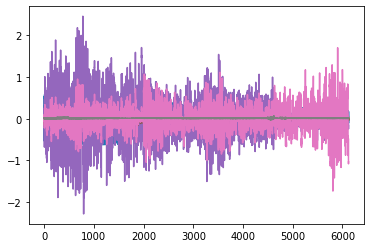

In [374]:
plt.plot(dataNormal)
plt.show()

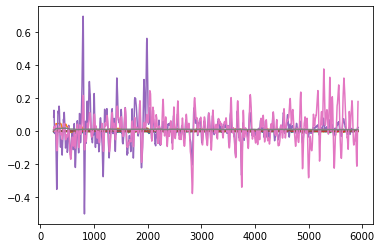

In [391]:
dataNormal = dataNormal.rolling(window=27).mean().dropna()
data6g = data6g.rolling(window=27).mean().dropna()
data10g = data10g.rolling(window=27).mean().dropna()
data15g = data15g.rolling(window=27).mean().dropna()
data20g = data20g.rolling(window=27).mean().dropna()
data25g = data25g.rolling(window=27).mean().dropna()
data30g = data30g.rolling(window=27).mean().dropna()
data35g = data35g.rolling(window=27).mean().dropna()
dataNormal = dataNormal[100:-100]
data6g = data6g[100:-100]
data10g = data10g[100:-100]
data15g = data15g[100:-100]
data20g = data20g[100:-100]
data25g = data25g[100:-100]
data30g = data30g[100:-100]
data35g = data35g[100:-100]
plt.plot(dataNormal)
plt.show()

In [392]:
 #new column, with single digit indicator of for fault type 
n1 = pd.DataFrame(np.zeros(int(len(dataNormal)),dtype=int)) #0 for no fault
n2 = pd.DataFrame(np.ones(int(len(data6g)),dtype=int)) #1-7 for imbalance of 6g-35g imbalance
n3 = pd.DataFrame(np.full((int(len(data10g)),1),2))
n4 = pd.DataFrame(np.full((int(len(data15g)),1),3))
n5 = pd.DataFrame(np.full((int(len(data20g)),1),4))
n6 = pd.DataFrame(np.full((int(len(data25g)),1),5))
n7 = pd.DataFrame(np.full((int(len(data30g)),1),6))
n8 = pd.DataFrame(np.full((int(len(data35g)),1),7))
y = pd.concat([n1,n2,n3,n4,n5,n6,n7,n8], ignore_index=True)#concatenate all y columns together
y

,0
0,0
1,0
2,0
3,0
4,0
...,...
44177,7
44178,7
44179,7
44180,7


In [393]:
X = pd.concat([dataNormal,data6g,data10g,data15g,data20g,data25g,data30g,data35g],ignore_index=True)
X

,0,1,2,3,4,5,6,7
0,-0.002777,0.011991,-0.001192,0.000425,0.088545,0.003242,0.012961,0.007507
1,-0.002646,0.012094,-0.001219,0.000423,0.098944,0.003312,0.015146,0.007509
2,-0.002570,0.011890,-0.001251,0.000418,0.110212,0.003355,0.018111,0.007497
3,-0.002479,0.011407,-0.001265,0.000407,0.121088,0.003400,0.021787,0.007517
4,-0.002264,0.011783,-0.001217,0.000408,0.127023,0.003395,0.024893,0.007532
...,...,...,...,...,...,...,...,...
44177,-0.002936,0.002453,0.001879,0.000384,0.013999,0.004007,0.116106,-0.005898
44178,-0.002487,0.002381,0.000166,0.000092,0.014919,0.004221,0.142108,-0.006444
44179,-0.002561,0.001679,-0.000693,0.000146,0.015481,0.004366,0.168109,-0.006991
44180,-0.003195,0.000842,-0.000134,0.000407,0.015754,0.004477,0.193032,-0.007529


In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [395]:
X_test.shape

(11046, 8)

In [396]:
y_train.shape

(33136, 1)

In [397]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(units= 32, activation='relu', input_shape=(8,)))
model.add(tf.keras.layers.Dense(units= 64, activation='relu'))
model.add(tf.keras.layers.Dense(units= 128, activation='relu'))
model.add(tf.keras.layers.Dense(units= 256, activation='relu'))
model.add(tf.keras.layers.Dense(units= 512, activation='relu'))
model.add(tf.keras.layers.Dense(units= 256, activation='relu'))
model.add(tf.keras.layers.Dense(units= 128, activation='relu'))
model.add(tf.keras.layers.Dense(units= 64, activation='relu'))
model.add(tf.keras.layers.Dense(units= 32, activation='relu'))
model.add(tf.keras.layers.Dense(units= 8, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_208 (Dense)           (None, 32)                288       
                                                                 
 dense_209 (Dense)           (None, 64)                2112      
                                                                 
 dense_210 (Dense)           (None, 128)               8320      
                                                                 
 dense_211 (Dense)           (None, 256)               33024     
                                                                 
 dense_212 (Dense)           (None, 512)               131584    
                                                                 
 dense_213 (Dense)           (None, 256)               131328    
                                                                 
 dense_214 (Dense)           (None, 128)             

In [398]:
hist = model.fit(X_train , y_train , epochs=100, validation_split=0.2)

Epoch 1/100
829/829 [==============================] - 6s 7ms/step - loss: 1.5096 - accuracy: 0.3655 - val_loss: 1.3256 - val_accuracy: 0.4101
Epoch 2/100
829/829 [==============================] - 5s 7ms/step - loss: 1.2155 - accuracy: 0.5014 - val_loss: 1.4252 - val_accuracy: 0.4218
Epoch 3/100
829/829 [==============================] - 5s 7ms/step - loss: 1.1082 - accuracy: 0.5507 - val_loss: 1.1575 - val_accuracy: 0.5202
Epoch 4/100
829/829 [==============================] - 7s 8ms/step - loss: 1.0610 - accuracy: 0.5715 - val_loss: 0.9877 - val_accuracy: 0.6062
Epoch 5/100
829/829 [==============================] - 5s 6ms/step - loss: 1.0391 - accuracy: 0.5768 - val_loss: 1.1260 - val_accuracy: 0.5367
Epoch 6/100
829/829 [==============================] - 5s 7ms/step - loss: 1.0022 - accuracy: 0.5916 - val_loss: 0.9905 - val_accuracy: 0.6033
Epoch 7/100
829/829 [==============================] - 5s 7ms/step - loss: 0.9759 - accuracy: 0.6068 - val_loss: 0.9741 - val_accuracy: 0.5949

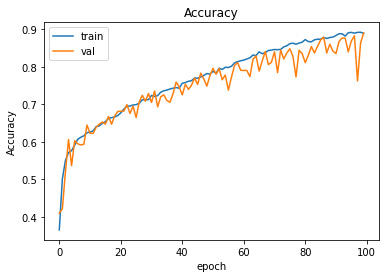

In [399]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

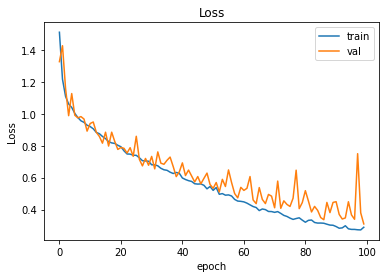

In [400]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [416]:
model.evaluate(X_test, y_test)

346/346 [==============================] - 1s 2ms/step - loss: 0.3276 - accuracy: 0.8825


[0.3276081383228302, 0.882491409778595]

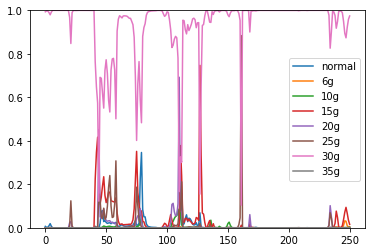

In [419]:
X_pred= data30g.loc[1000:1250]
y_pred= model.predict(X_pred)
y_pred
plt.plot(y_pred)
plt.ylim(0,1)
plt.legend(['normal', '6g','10g', '15g','20g','25g','30g','35g'])
plt.show()

In [386]:
nb1 = pd.DataFrame(np.ones(int(len(dataNormal)),dtype=int))
nb2 = pd.DataFrame(np.zeros(int(len(data6g)),dtype=int))
nb3 = pd.DataFrame(np.full((int(len(data10g)),1),0))
nb4 = pd.DataFrame(np.full((int(len(data15g)),1),0))
nb5 = pd.DataFrame(np.full((int(len(data20g)),1),0))
nb6 = pd.DataFrame(np.full((int(len(data25g)),1),0))
nb7 = pd.DataFrame(np.full((int(len(data30g)),1),0))
nb8 = pd.DataFrame(np.full((int(len(data35g)),1),0))
yb = pd.concat([nb1,nb2,nb3,nb4,nb5,nb6,nb7,nb8], ignore_index=True)
yb

,0
0,1
1,1
2,1
3,1
4,1
...,...
45985,0
45986,0
45987,0
45988,0


In [387]:
Xb = pd.concat([dataNormal,data6g,data10g,data15g,data20g,data25g,data30g,data35g],ignore_index=True)

In [388]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb, yb, test_size=0.25, shuffle=True)

In [389]:
modelb = tf.keras.models.Sequential()

modelb.add(tf.keras.layers.Dense(units=32, activation='relu', input_shape=(8,)))
modelb.add(tf.keras.layers.Dense(units= 64, activation='relu'))
modelb.add(tf.keras.layers.Dense(units= 128, activation='relu'))
modelb.add(tf.keras.layers.Dense(units= 256, activation='relu'))
modelb.add(tf.keras.layers.Dense(units= 128, activation='relu'))
modelb.add(tf.keras.layers.Dense(units= 64, activation='relu'))
modelb.add(tf.keras.layers.Dense(units= 32, activation='relu'))
modelb.add(tf.keras.layers.Dense(units= 1, activation='sigmoid'))

modelb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelb.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 32)                288       
                                                                 
 dense_201 (Dense)           (None, 64)                2112      
                                                                 
 dense_202 (Dense)           (None, 128)               8320      
                                                                 
 dense_203 (Dense)           (None, 256)               33024     
                                                                 
 dense_204 (Dense)           (None, 128)               32896     
                                                                 
 dense_205 (Dense)           (None, 64)                8256      
                                                                 
 dense_206 (Dense)           (None, 32)              

In [390]:
y_train_b.describe()

,0
count,34492.000000
mean,0.128407
std,0.334547
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [406]:
histb = modelb.fit(X_train_b , y_train_b , epochs=100, validation_split=0.2)

Epoch 1/100
863/863 [==============================] - 4s 3ms/step - loss: 0.2553 - accuracy: 0.9033 - val_loss: 0.2253 - val_accuracy: 0.9149
Epoch 2/100
863/863 [==============================] - 3s 3ms/step - loss: 0.2023 - accuracy: 0.9268 - val_loss: 0.1890 - val_accuracy: 0.9313
Epoch 3/100
863/863 [==============================] - 3s 3ms/step - loss: 0.1734 - accuracy: 0.9389 - val_loss: 0.1706 - val_accuracy: 0.9448
Epoch 4/100
863/863 [==============================] - 3s 3ms/step - loss: 0.1586 - accuracy: 0.9430 - val_loss: 0.1407 - val_accuracy: 0.9509
Epoch 5/100
863/863 [==============================] - 3s 3ms/step - loss: 0.1404 - accuracy: 0.9502 - val_loss: 0.1186 - val_accuracy: 0.9603
Epoch 6/100
863/863 [==============================] - 3s 3ms/step - loss: 0.1316 - accuracy: 0.9546 - val_loss: 0.1321 - val_accuracy: 0.9536
Epoch 7/100
863/863 [==============================] - 3s 3ms/step - loss: 0.1205 - accuracy: 0.9572 - val_loss: 0.1088 - val_accuracy: 0.9620

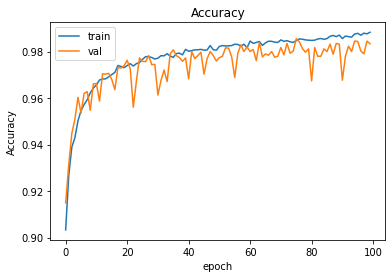

In [408]:
plt.plot(histb.history['accuracy'])
plt.plot(histb.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

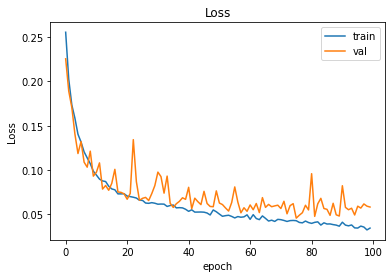

In [409]:
plt.plot(histb.history['loss'])
plt.plot(histb.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [420]:
modelb.evaluate(X_test_b, y_test_b)

360/360 [==============================] - 1s 2ms/step - loss: 0.0459 - accuracy: 0.9856


[0.04585926607251167, 0.9856497049331665]

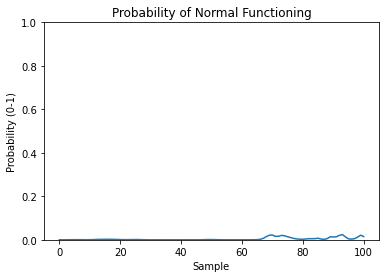

array([[8.11955106e-05],
       [1.14667833e-04],
       [1.45673752e-04],
       [2.63571739e-04],
       [3.80218029e-04],
       [5.23120165e-04],
       [5.82069159e-04],
       [6.12229109e-04],
       [4.13656235e-04],
       [3.37660313e-04],
       [4.52101231e-04],
       [8.06003809e-04],
       [1.51893497e-03],
       [1.92403793e-03],
       [2.08359957e-03],
       [2.31990218e-03],
       [2.44808197e-03],
       [2.25940347e-03],
       [1.87170506e-03],
       [1.57353282e-03],
       [1.20976567e-03],
       [8.55743885e-04],
       [7.13229179e-04],
       [8.10474157e-04],
       [1.07479095e-03],
       [1.21909380e-03],
       [1.12754107e-03],
       [7.66992569e-04],
       [3.53753567e-04],
       [8.80923544e-05],
       [3.37876299e-05],
       [1.78553473e-05],
       [7.78036429e-06],
       [3.14402200e-06],
       [2.55342820e-06],
       [4.29225702e-06],
       [1.01032438e-05],
       [2.09798964e-05],
       [2.80598288e-05],
       [3.29554969e-05],


In [423]:
X_pred_b= data20g.loc[1200:1300]
y_pred_b= modelb.predict(X_pred_b)
plt.plot(y_pred_b)
plt.title('Probability of Normal Functioning')
plt.ylabel('Probability (0-1)')
plt.xlabel('Sample')
plt.ylim(0,1)
plt.show()
y_pred_b